In [97]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from skimage.transform import rotate
from skimage import io
import cv2 as cv

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from numpy.random import seed

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [98]:
RANDOM_STATE = 12
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Brief Description of the Problem and Data

The data consists of .tif files, each represent a 96x96x3 image with pixel values ranging from 0 to 255. Our training dataset consists of 220,025 labeled images, where a label of 1 indicates the presence of a cancerous cell.

These images are structured as thousands of 96x96 pixel images with 3 channels, each associated with a unique ID and label. We have two dataset a pre-split training set comprising 220,025 images and a test set with around 57,500 images. To facilitate machine learning model development, we are provided with an additional dataframe containing id and label columns. The id links to the unique image ID in the training directory and the 'label' represents the classification category: 0 represents non-cancerous and 1 represents a cancerous image. It's worth noting that there are no missing values in the dataset, streamlining the preprocessing process.

In [99]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# Exploratory Data Analysis



Based on the below code we can see that the train data set is made up of 220025 total records all containg two features id and label. The test data sample distribution for the label feature is 130908 labled with 0 and 89117 labeled with 1. Based off of this we can conclude that all of our test samples have a label that detects if cancer is present or not, so we will not need to clean this aspect of the data. We can also see that the amount of test records is 57458.  

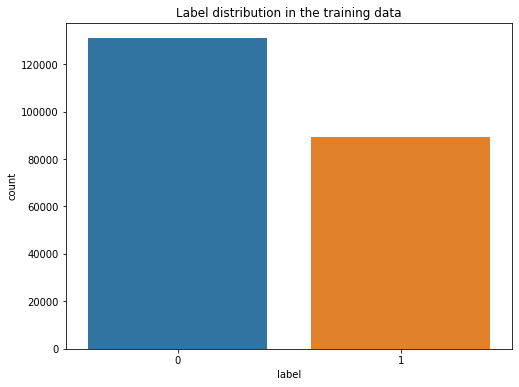

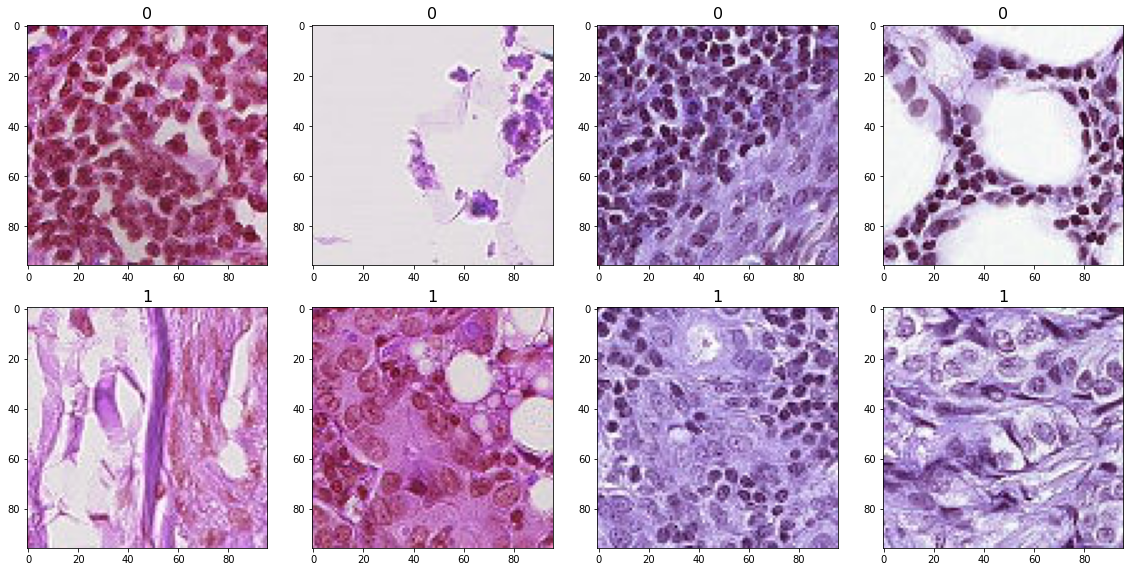

In [101]:
import cv2
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data)
plt.title('Label distribution in the training data')
plt.show()
 
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    
    
draw_category_images('label',4, train_data, train_path)

**More EDA and Preprocessing Techniques**

First, I checked for missing data in the training setand there is none. The area of interest in the images is the center pixels, and currently, they're sized 96x96x3, with '3' representing the RGB channels. We'll keep this setup unchanged for now. Augmentations to enhance model learning aren't applied at this stage for simplicity. However, we'll shuffle the data to prevent the model from learning based on image order, which could affect training. Additionally, we'll split the data into training and validation sets to refine the model. Lastly, we'll normalize the pixel values during training by dividing them by 255.0, which aids in data processing and model training. All of this is dont in the below code when the generators are made.

# DModel Architecture

**First model:**
It consists of two convolutional layers with 16 filters each, followed by max-pooling layers to downsize the feature maps. A flatten layer is used to convert the 2D feature maps to a 1D vector, connecting them to a single neuron dense layer with sigmoid activation. Input images are expected to be 96x96 pixels with 3 channels (RGB), and the model's compilation includes binary cross-entropy as the loss function and accuracy as a metric. Overall, it's a straightforward CNN architecture for binary image classification tasks.







**Second model:**
Is a more complex CNN designed for binary image classification. It starts with two convolutional layers to extract features from images. Then max-pooling to reduce their size. A dropout layer helps prevent overfitting, while batch normalization normalizes training. Another convolutional layer captures more subtle patterns. The model then flattens the features and passes them through a single neuron dense layer for classification. It's trained on 96x96 pixel RGB images using binary cross-entropy loss and evaluated using accuracy. The Adam optimizer isalso used with a learning rate of 0.001. Overall, the second model combines advanced techniques for better performance in binary image classification.

In [78]:
# set model constants
BATCH_SIZE = 256

In [79]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [80]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [81]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(96,96))        # original image = (96, 96) 

Found 187022 validated image filenames belonging to 2 classes.


In [82]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(96,96))       # original image = (96, 96) 

Found 33003 validated image filenames belonging to 2 classes.


In [83]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

**First model**

In [84]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():
    
    #create model
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_one.build(input_shape=(BATCH_SIZE, 96, 96, 3))        
    
    #compile
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
#quick look at model
model_one.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (256, 94, 94, 16)         448       
_________________________________________________________________
conv2d_7 (Conv2D)            (256, 92, 92, 16)         2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (256, 46, 46, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (256, 33856)              0         
_________________________________________________________________
dense_2 (Dense)              (256, 1)                  33857     
Total params: 36,625
Trainable params: 36,625
Non-trainable params: 0
_________________________________________________________________


In [85]:

history_model_one = model_one.fit_generator(
                        train_generator,
                        epochs = 1,
                        validation_data = valid_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



731/731 [==============================] - 670s 915ms/step - loss: 0.6673 - accuracy: 0.6597 - auc_2: 0.6905 - val_loss: 0.5453 - val_accuracy: 0.7283 - val_auc_2: 0.8062


**Second model**


In [86]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    model_two = Sequential()
    
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))
    
    model_two.build(input_shape=(BATCH_SIZE, 96, 96, 3))
    
    adam_optimizer = Adam(learning_rate=0.001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

model_two.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (256, 94, 94, 16)         448       
_________________________________________________________________
conv2d_9 (Conv2D)            (256, 92, 92, 16)         2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (256, 46, 46, 16)         0         
_________________________________________________________________
dropout (Dropout)            (256, 46, 46, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (256, 46, 46, 16)         64        
_________________________________________________________________
conv2d_10 (Conv2D)           (256, 44, 44, 32)         4640      
_________________________________________________________________
flatten_3 (Flatten)          (256, 61952)             

In [87]:
history_model_two = model_two.fit_generator(
                        train_generator,
                        epochs = 1,
                        validation_data = valid_generator)

731/731 [==============================] - 873s 1s/step - loss: 0.4552 - accuracy: 0.8065 - auc_3: 0.8710 - val_loss: 1.0139 - val_accuracy: 0.6086 - val_auc_3: 0.8997


# Results and Analysis

The two models presented both have uinque architectural designs and training performances. The first model comprises two convolutional layers followed by max-pooling and a flatten layer culminating into a dense layer with sigmoid activation, totaling 36,625 parameters. In comparison, the second model, while resembling the first, incorporates additional layers such as dropout, batch normalization, and an extra convolutional layer, resulting in a more complex structure with 69,425 parameters. Training results indicate that the second model outperforms the first in terms of training accuracy and validation accuracy. However, the second model also demonstrates a considerably higher validation loss. This suggests that potential overfitting to the training data occured. To address this adjustments to regularization techniques like dropout and batch normalization may be needed and  hyperparameter tuning inparticularly with optimizing the learning rate.

#  Conclusion

In summary, the second model performs better in training but might overfit. Balancing complexity and generalization is key. Further adjustments, like fine-tuning regularization and hyperparameters, are needed for the second model. Regular evaluation on validation data guides refinement, ensuring effectiveness. The choice between models depends on task needs, considering both performance and generalization

# Submiting

In [89]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [90]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(96,96),        
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [91]:
predictions = model_two.predict(test_generator, verbose=1)

57458/57458 [==============================] - 468s 8ms/step


In [92]:
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [94]:
submission_df.to_csv('submission.csv', index=False)